In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg
import sdeint

Рассмотрим точность решения на основе уравнения с известным решением:
$$
\boldsymbol{x}(t) = \exp\left\{ \hat{A}t + \sum\limits_i \hat{B}_i W_i \right\}\boldsymbol{x}_0
$$
На основе формулы Ито конструируем стохастическое дифференциальное уравнение с таким решением:
$$
d\boldsymbol{x} = \left(\hat{A} + \dfrac{1}{2} \sum\limits_{i}\hat{B}_i^2 \right)\boldsymbol{x} dt + \sum\limits_i \hat{B}_i\boldsymbol{x}dW_i  
$$
Положим здесь:
$$
\hat{A} = \begin{pmatrix}
-\frac{1}{10} & -2\\
2 & -\frac{1}{10}
\end{pmatrix},  \qquad \hat{B}_1 = \begin{pmatrix}
0 & -0.1\\
0.1 & -0.1
\end{pmatrix},  \qquad \hat{B}_2 = \begin{pmatrix}
0 & -0.2\\
-0.2 & 0.3
\end{pmatrix}
$$

In [59]:
A = np.array([[-0.1, -2.0],
              [ 2.0, -0.1]])

B_1 = 10*np.array([[0., -0.01],
              [ 0.01, -0.01]])
B_2 = 10*np.array([[0., -0.02],
              [ -0.02, 0.03]])

B_1 = np.zeros((2,2))
#B_2 = np.zeros((2,2))

#A = np.array([[-0.5, 0],
#              [ 0, -0.5]])

#B_2 = np.array([[0., -1.],
#              [ 1., 0.]])


B = np.diag([0.5, 0.5]) # diagonal, so independent driving Wiener processes

tspan = np.linspace(0.0, 3.5, 10001)
dt = tspan[1:] - tspan[:-1]
#dW = np.random.normal(size=(len(tspan)-1, 2))*np.reshape(np.sqrt(dt), (-1,1))
dW = sdeint.deltaW(len(tspan)-1, 2, dt[0])
#dW[np.logical_not(np.logical_or(np.logical_and(tspan[1:] > 13*np.pi/12, tspan[1:] < 14*np.pi/12), np.logical_and(tspan[1:] > 7*np.pi/12, tspan[1:] < 8*np.pi/12)))] = 0.
x0 = np.array([3.0, 0.0])

In [60]:
# Exact solution
W = np.vstack(([0., 0.], np.cumsum(dW, axis=0)))
x_th = np.array([linalg.expm(A*t + B_1*w[0] + B_2*w[1]) @ x0 for t,w in zip(tspan, W)])


[]

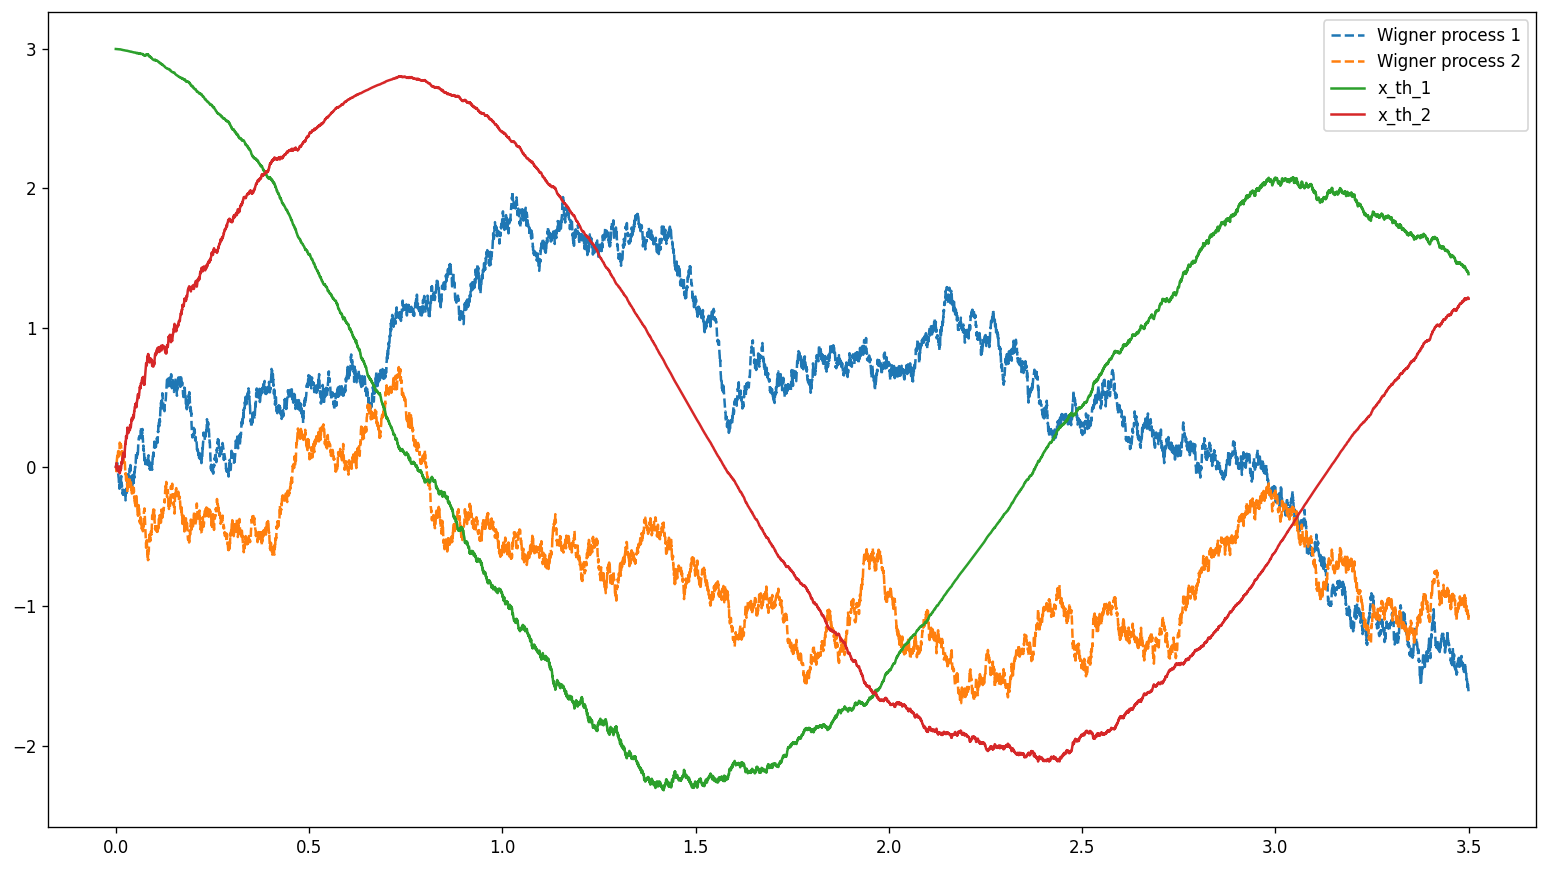

In [61]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, W, "--", label=("Wigner process 1", "Wigner process 2"))
plt.plot(tspan, x_th, label=("x_th_1", "x_th_2"))
plt.legend(loc="upper right")
plt.plot()

In [62]:
def Iwik_wrapper(dW, h, generator=None):
    n = int(np.ceil(np.sqrt(1/h)))
    print(n)
    return sdeint.Iwik(dW, h, n=n, generator=generator)

In [63]:
C = A + 0.5 * B_1 @ B_1 + 0.5 * B_2 @ B_2

def f(x, t):
    return C @ x

D = np.transpose([B_1, B_2], axes=(1, 0, 2))
def G(x, t):
    return D @ x
    #return np.array([B_1@x, B_2@x])

x_eu = sdeint.itoEuler(f, G, x0, tspan, dW=dW)
x_sri = sdeint.itoSRI2(f, G, x0, tspan, Imethod=Iwik_wrapper, dW=dW)

54


In [64]:
x_mine = []
x_mine.append(x0)
x_c = x0
delt = dt[0]
for deltw in dW:
    x_c = (np.identity(2) + A*delt + B_1*deltw[0] + B_2*deltw[1]) @ x_c
    x_mine.append(x_c)
    
x_mine = np.array(x_mine)

Давайте сменим координаты на полярные: $(x_1, x_2) \rightarrow (\sqrt{x_1^2 + x_2^2}, \text{arctg}\frac{x_2}{x_1})$
Тогда уравнения (с учетом только одного вигнеровского процесса) будут:
$$
\begin{gather}
\dot{r} = \gamma + \frac{1}{2r}\left[ (b_{11} + b_{22}) + (b_{11}-b_{22})\cos 2\phi + (b_{12} + b_{21})\sin 2\phi \right]dW\\
\dot{\phi} = \omega + \frac{1}{2}\left[ (b_{21} - b_{12}) + (b_{21} + b_{12})\cos 2\phi + (b_{22}-b_{11})\sin 2\phi \right]dW
\end{gather}
$$
$$
\omega = A_{21} = -A_{12},\qquad \gamma = A_{11} = A_{22}
$$

In [65]:
omega = A[1,0]
gamma = A[0,0]

def f_s(x, t):
    return np.array([gamma, omega])

def G_s(x, t):
    return np.array([[0 , 1/2/x[0] * ( (B_2[0,0] + B_2[1,1]) + (-B_2[0,0] + B_2[1,1])*np.cos(2*x[1]) + (B_2[1,0] + B_2[0,1])*np.sin(2*x[1]) )], 
                     [0, 1/2 * ( (B_2[1,0] - B_2[0,1]) + (B_2[1,0] + B_2[0,1])*np.cos(2*x[1]) + (B_2[1,1] - B_2[0,0])*np.sin(2*x[1]) )]])

z0 = np.array([np.sqrt(x0[0]**2 + x0[1]**2), np.arctan2(x0[1], x0[0])])

z_eu = sdeint.itoEuler(f_s, G_s, z0, tspan, dW=dW)
z_sri = sdeint.itoSRI2(f_s, G_s, z0, tspan, Imethod=Iwik_wrapper, dW=dW)

54


In [66]:
x_s_eu = np.array([z_eu[:,0]*np.cos(z_eu[:,1]), z_eu[:,0]*np.sin(z_eu[:,1])]).T
x_s_sri = np.array([z_sri[:,0]*np.cos(z_sri[:,1]), z_sri[:,0]*np.sin(z_sri[:,1])]).T

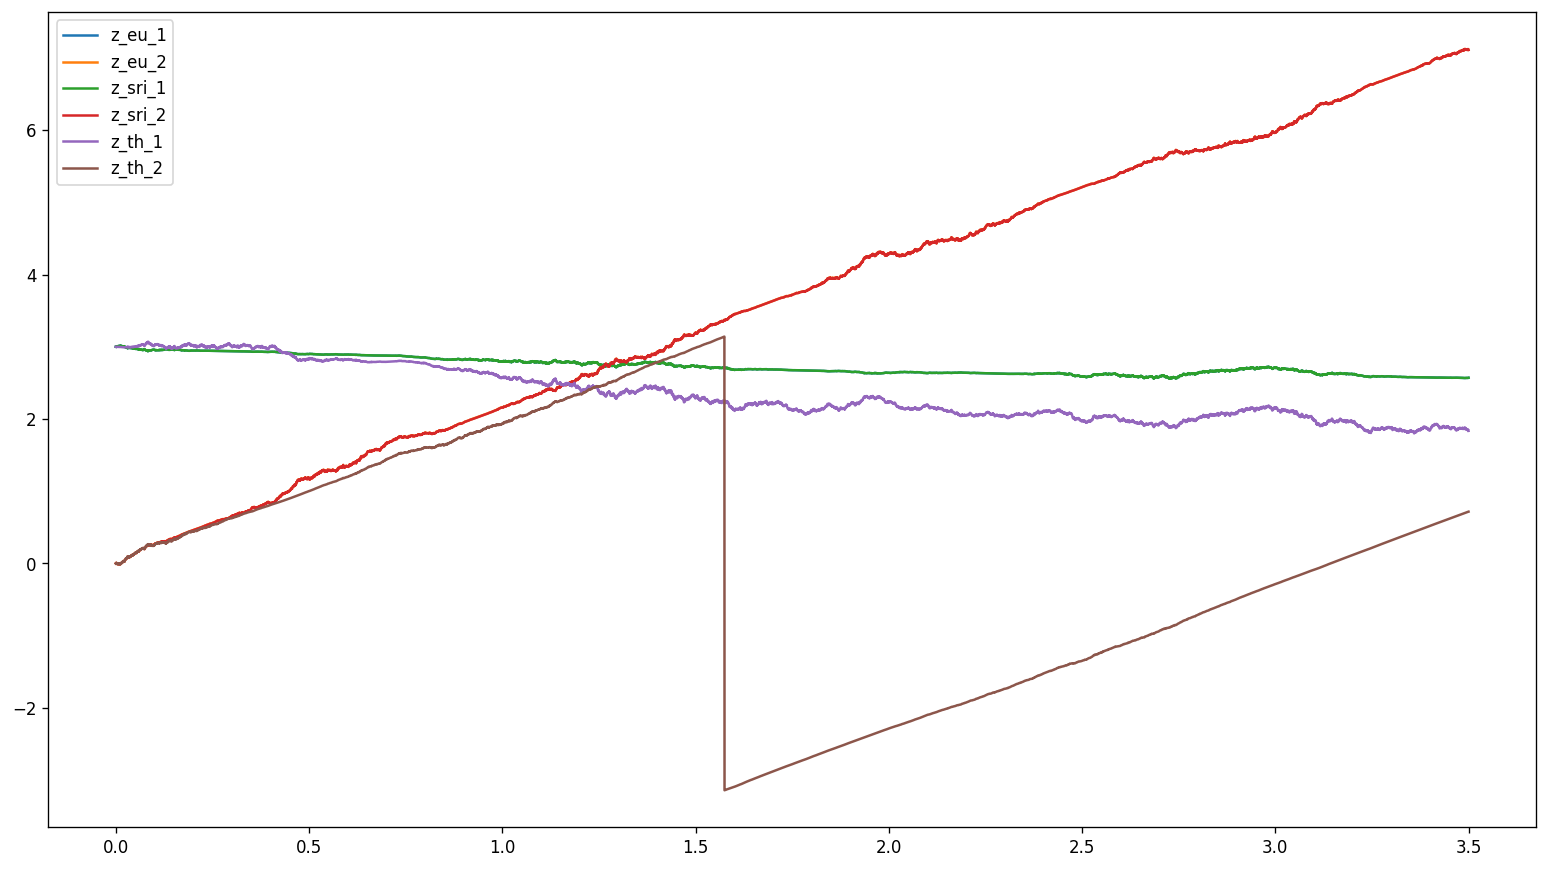

In [67]:
z_th = np.array([np.sqrt(x_th[:,0]**2 + x_th[:,1]**2), np.arctan2(x_th[:,1], x_th[:,0])]).T

plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, z_eu, label=("z_eu_1", "z_eu_2"))
plt.plot(tspan, z_sri, label=("z_sri_1", "z_sri_2"))
plt.plot(tspan, z_th, label=("z_th_1", "z_th_2"))
plt.legend()

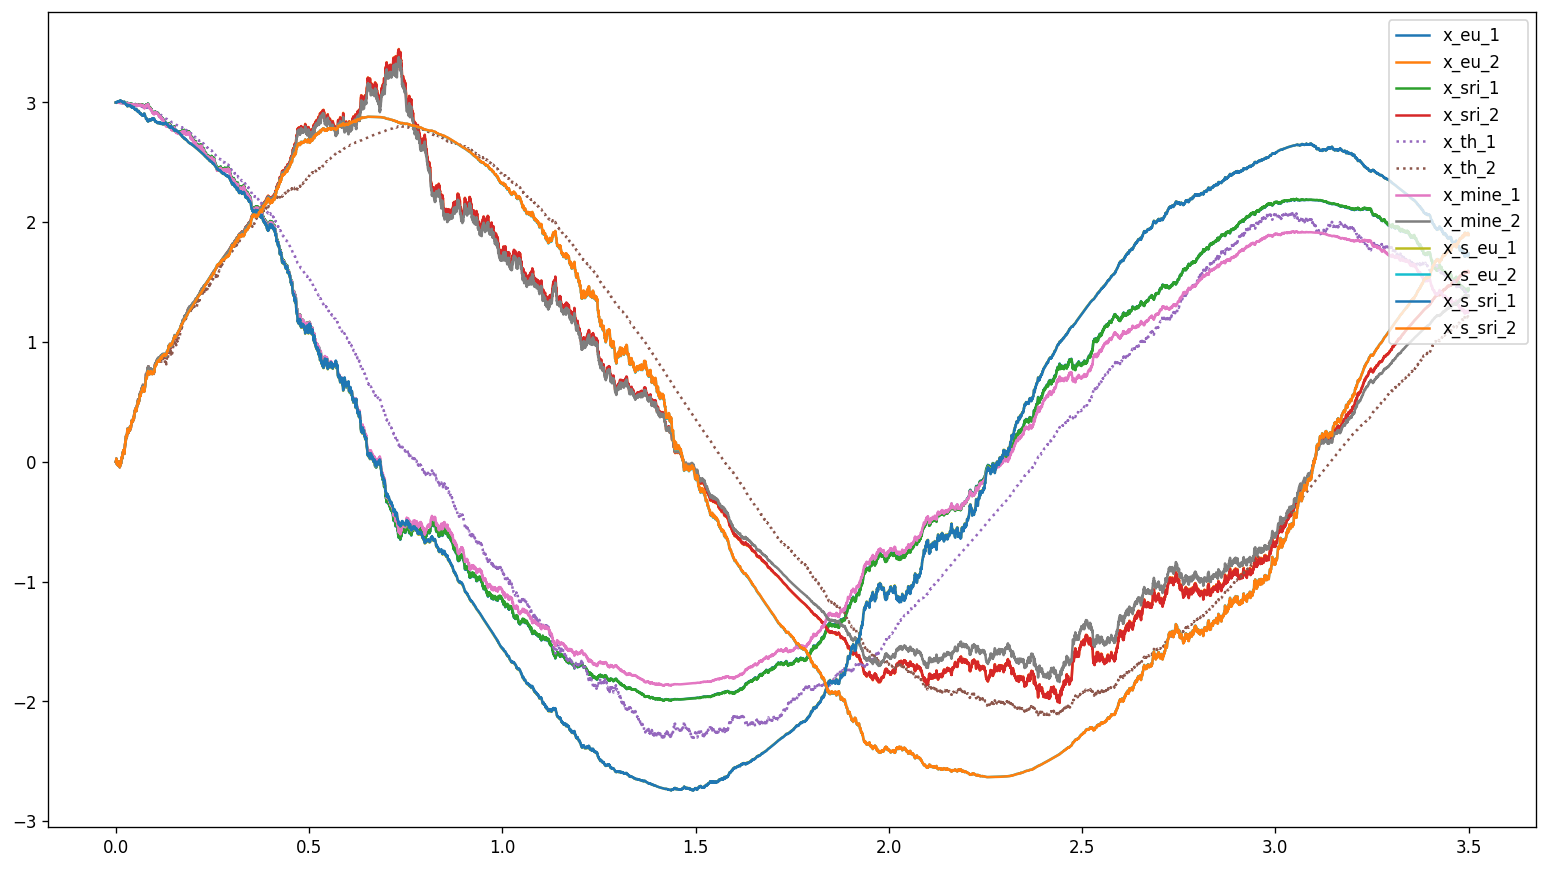

In [68]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, x_eu, label=("x_eu_1", "x_eu_2"))
plt.plot(tspan, x_sri, label=("x_sri_1", "x_sri_2"))
plt.plot(tspan, x_th, ":", label=("x_th_1", "x_th_2"))
plt.plot(tspan, x_mine, label=("x_mine_1", "x_mine_2"))
plt.plot(tspan, x_s_eu, label=("x_s_eu_1", "x_s_eu_2"))
plt.plot(tspan, x_s_sri, label=("x_s_sri_1", "x_s_sri_2"))
plt.legend(loc="upper right")
plt.savefig("main.pdf")

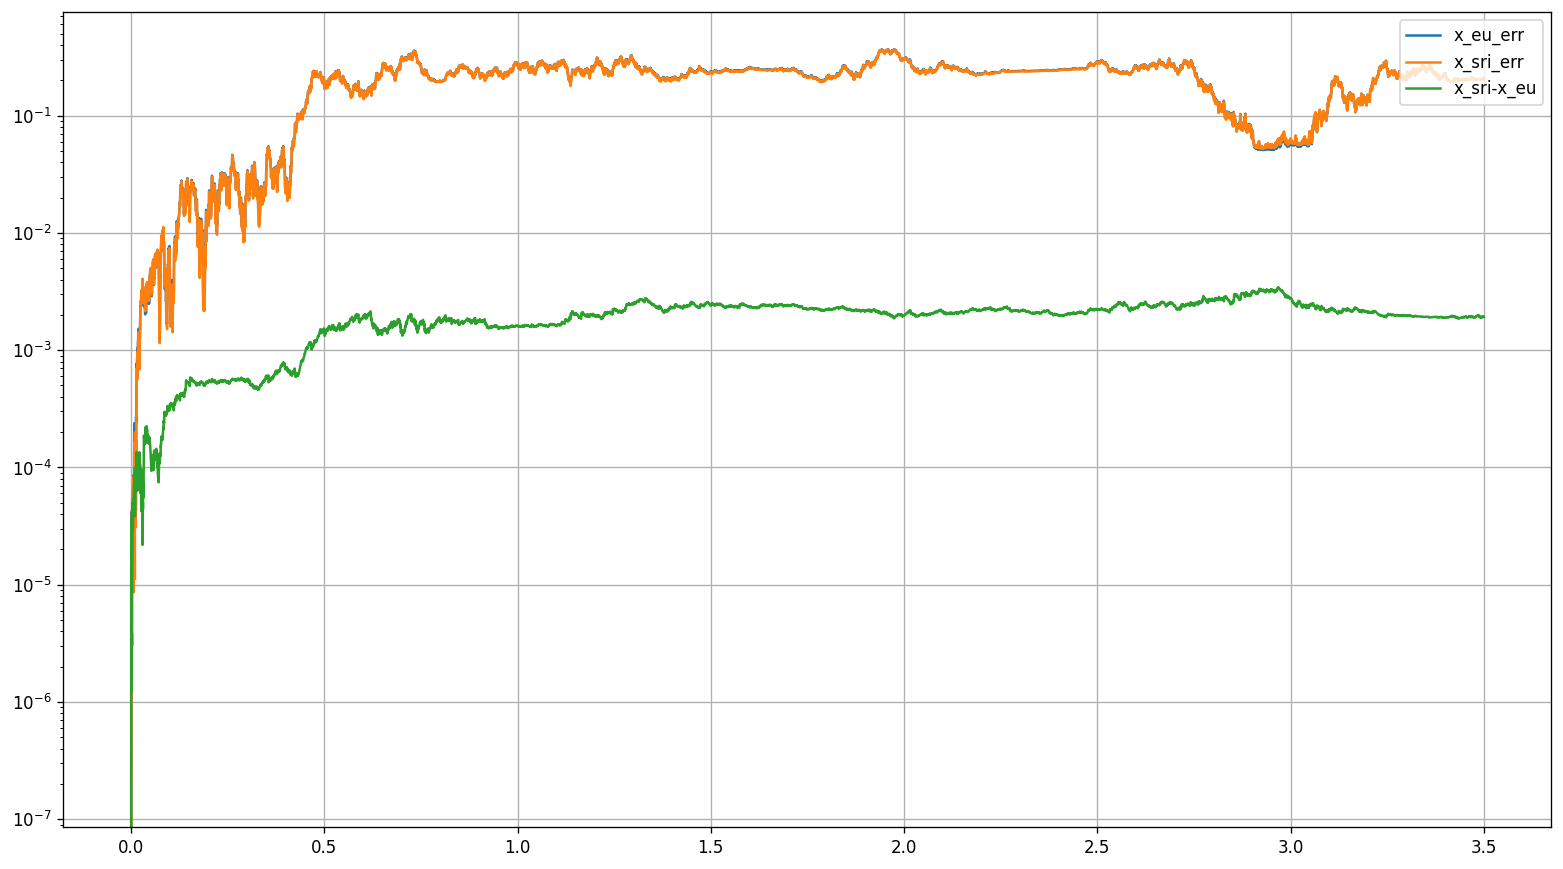

In [69]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, np.linalg.norm(x_eu-x_th, axis=1)/np.linalg.norm(x_th, axis=1), label="x_eu_err")
plt.plot(tspan, np.linalg.norm(x_sri-x_th, axis=1)/np.linalg.norm(x_th, axis=1), label="x_sri_err")
plt.plot(tspan, np.linalg.norm(x_sri-x_eu, axis=1)/np.linalg.norm(x_th, axis=1), label="x_sri-x_eu")
plt.yscale("log")
#plt.ylim((1e-3, 10))
plt.grid()
plt.legend(loc="upper right")
plt.savefig("smth.pdf")

Попробуем решить данную проблему заменой переменных, которая убирает зависимость от времени, а следовательно и колебательные процессы:
$$
\boldsymbol{x}(t) = \exp\left\{ \hat{A} t \right\}\boldsymbol{y}(t)
$$
Тогда уравнение на $y$:
$$
d\boldsymbol{y}(t) = e^{-\hat{A}t}\left( \dfrac{1}{2} \sum\limits_{i}\hat{B}_i^2 \right)e^{\hat{A}t}\boldsymbol{y} dt + \sum\limits_i e^{-\hat{A}t}\hat{B}_ie^{\hat{A}t}\boldsymbol{y}dW_i  
$$

In [70]:
Bs = 1/2 * (B_1 @ B_1  + B_2 @ B_2)
def fy(x, t):
    return linalg.expm(-A*t) @ Bs @ linalg.expm(A*t) @ x

def Gy(x, t):
    return np.array([linalg.expm(-A*t)@B_1@linalg.expm(A*t)@x, linalg.expm(-A*t)@B_2@linalg.expm(A*t)@x])

y_eu = sdeint.itoEuler(fy, Gy, x0, tspan, dW=dW)
y_sri = sdeint.itoSRI2(fy, Gy, x0, tspan, Imethod=Iwik_wrapper, dW=dW)

54


In [71]:
xy_eu = [linalg.expm(A*t)@y for t, y in zip(tspan, y_eu)]
xy_sri = [linalg.expm(A*t)@y for t, y in zip(tspan, y_sri)]

[]

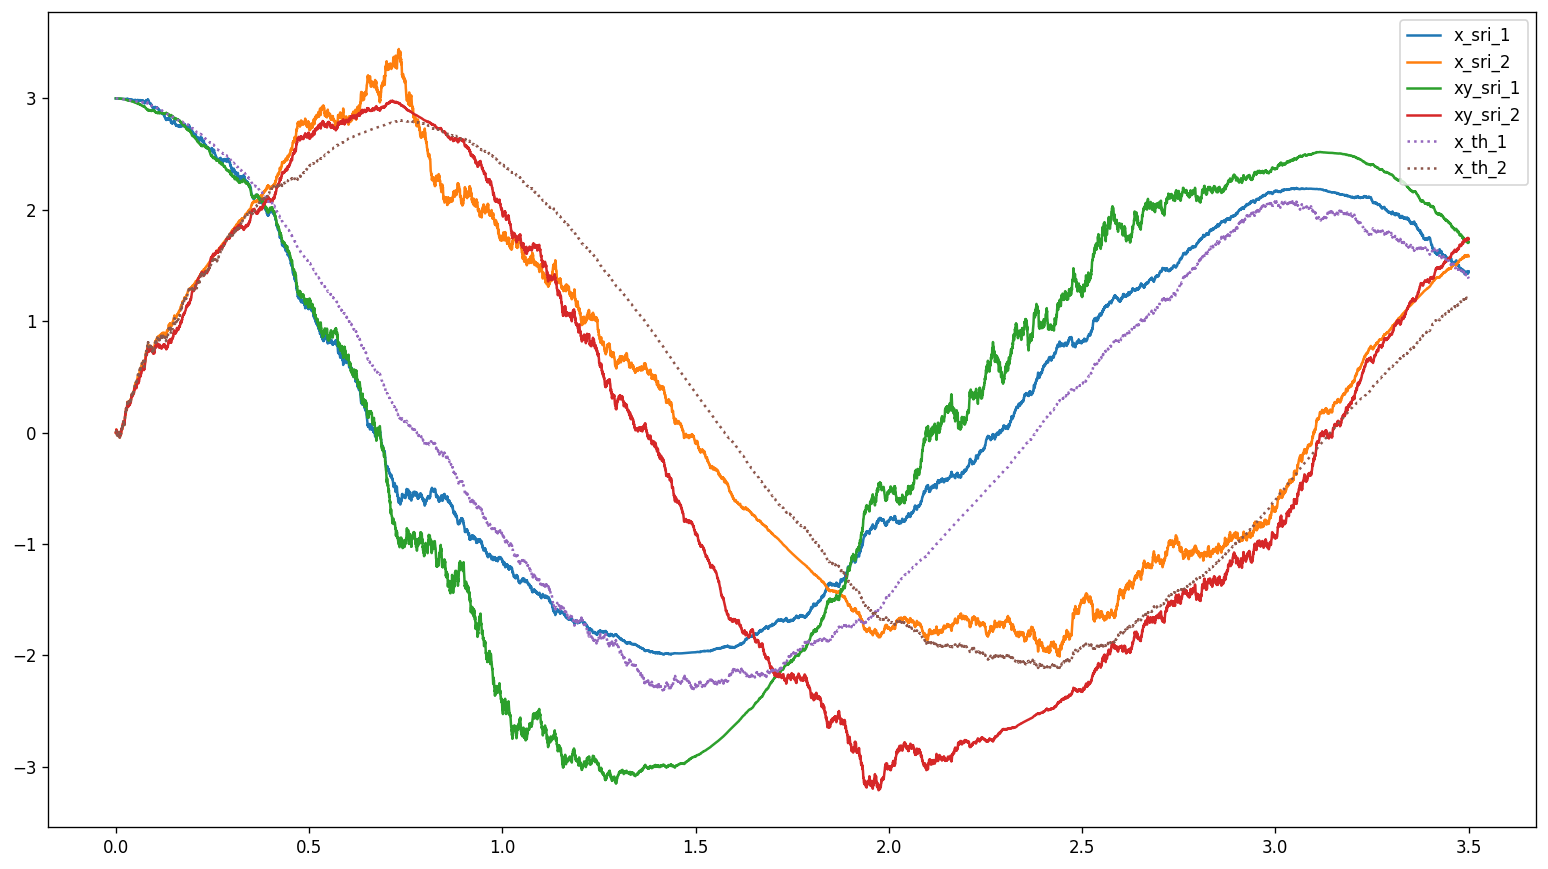

In [72]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, x_sri, label=("x_sri_1", "x_sri_2"))
plt.plot(tspan, xy_sri, label=("xy_sri_1", "xy_sri_2"))
plt.plot(tspan, x_th, ":", label=("x_th_1", "x_th_2"))
plt.legend(loc="upper right")
plt.plot()

In [73]:
y_th = [linalg.expm(-A*t)@x for t,x in zip(tspan, x_th)]

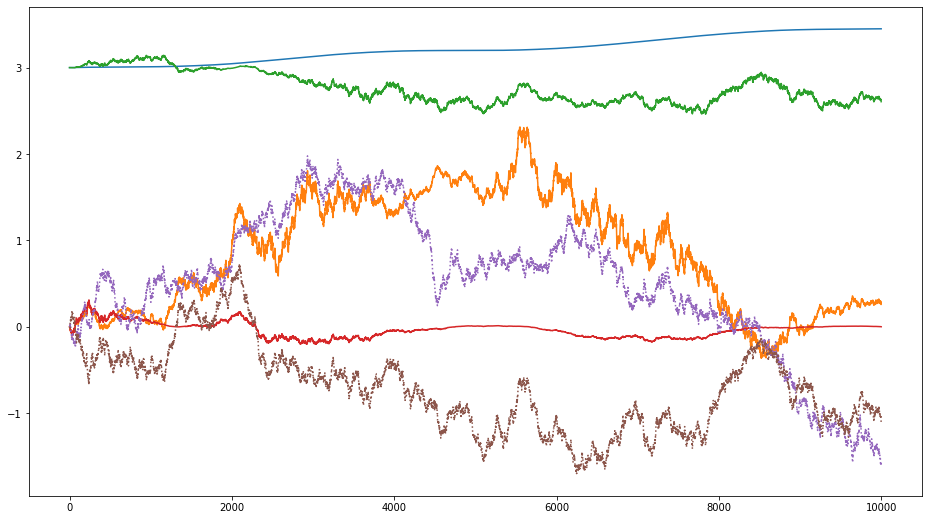

In [74]:
plt.figure(figsize=(16,9))
plt.plot(y_sri)
plt.plot(y_th)
plt.plot(W, ":")
plt.show()

Попробуем реализовать полностью неявную схему Эйлера-Маруямы:
$$
\boldsymbol{x}_{n+1} = \boldsymbol{x}_n + \hat{A}\boldsymbol{x}_{n+1} dt + \hat{B}_1\boldsymbol{x}_{n+1} dW_1 + \hat{B}_2\boldsymbol{x}_{n+1} dW_2
$$

In [79]:
x_impl = []
x_impl.append(x0)
x_c = x0
delt = dt[0]
for deltw in dW:
    x_c = linalg.solve((np.identity(2) - A*delt - B_1*deltw[0] - B_2*deltw[1]), x_c)  
    x_impl.append(x_c)
    
x_impl = np.array(x_impl)

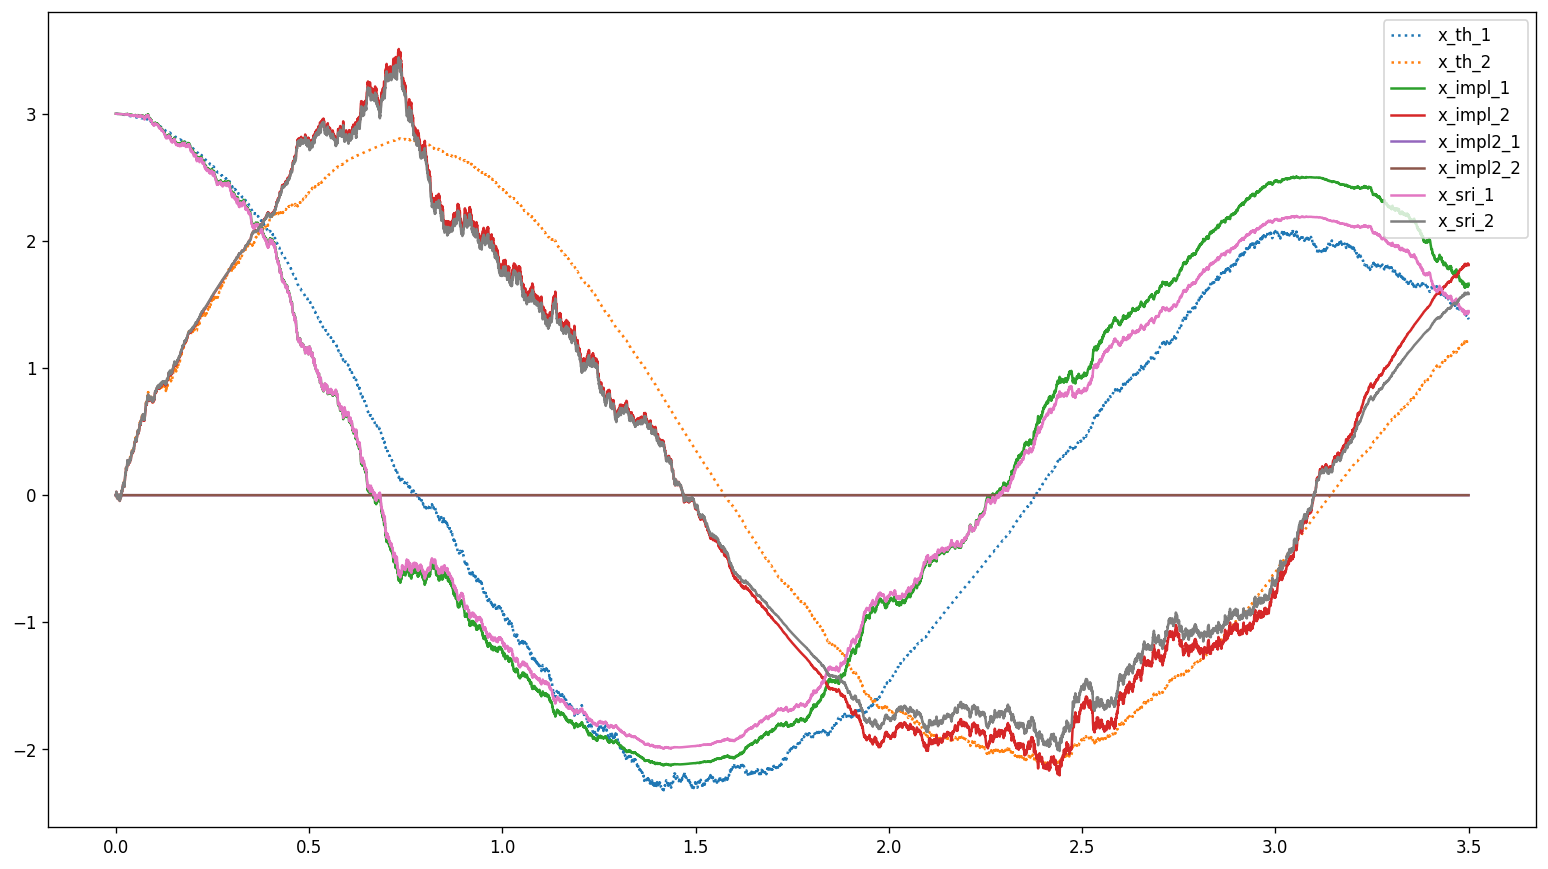

In [99]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, x_th, ":", label=("x_th_1", "x_th_2"))
plt.plot(tspan, x_impl, label=("x_impl_1", "x_impl_2"))
plt.plot(tspan, x_impl2, label=("x_impl2_1", "x_impl2_2"))
plt.plot(tspan, x_sri, label=("x_sri_1", "x_sri_2"))
plt.legend(loc="upper right")
plt.savefig("main.pdf")

-----------------------------------------------

Окей, протестируем для скалярного уравнения типа:
$$
x(t) = \exp\left\{ at + bW \right\}x_0
$$
Это решение СДУ:
$$
dx = \left( a + \frac{1}{2}b^2\right)xdt + bxdW
$$

In [30]:
a = -0.05
b = 0.5

tspan = np.linspace(0.0, 10.0, 10001)
dt = tspan[1:] - tspan[:-1]
#dW = np.random.normal(size=(len(tspan)-1, 2))*np.reshape(np.sqrt(dt), (-1,1))
dW = sdeint.deltaW(len(tspan)-1, 1, dt[0])
y0 = 3.0

In [31]:
# Exact solution
W = np.vstack(([0.], np.cumsum(dW, axis=0)))
y_th = y0*np.exp(a*tspan + b*W[:,0])

In [36]:
def f1(x, t):
    return (a+0.5*b**2)*x

def G1(x, t):
    return b*x

y_eu = sdeint.itoEuler(f1, G1, y0, tspan, dW=dW)
y_sri = sdeint.itoSRI2(f1, G1, y0, tspan, Imethod=sdeint.Iwik, dW=dW)

[]

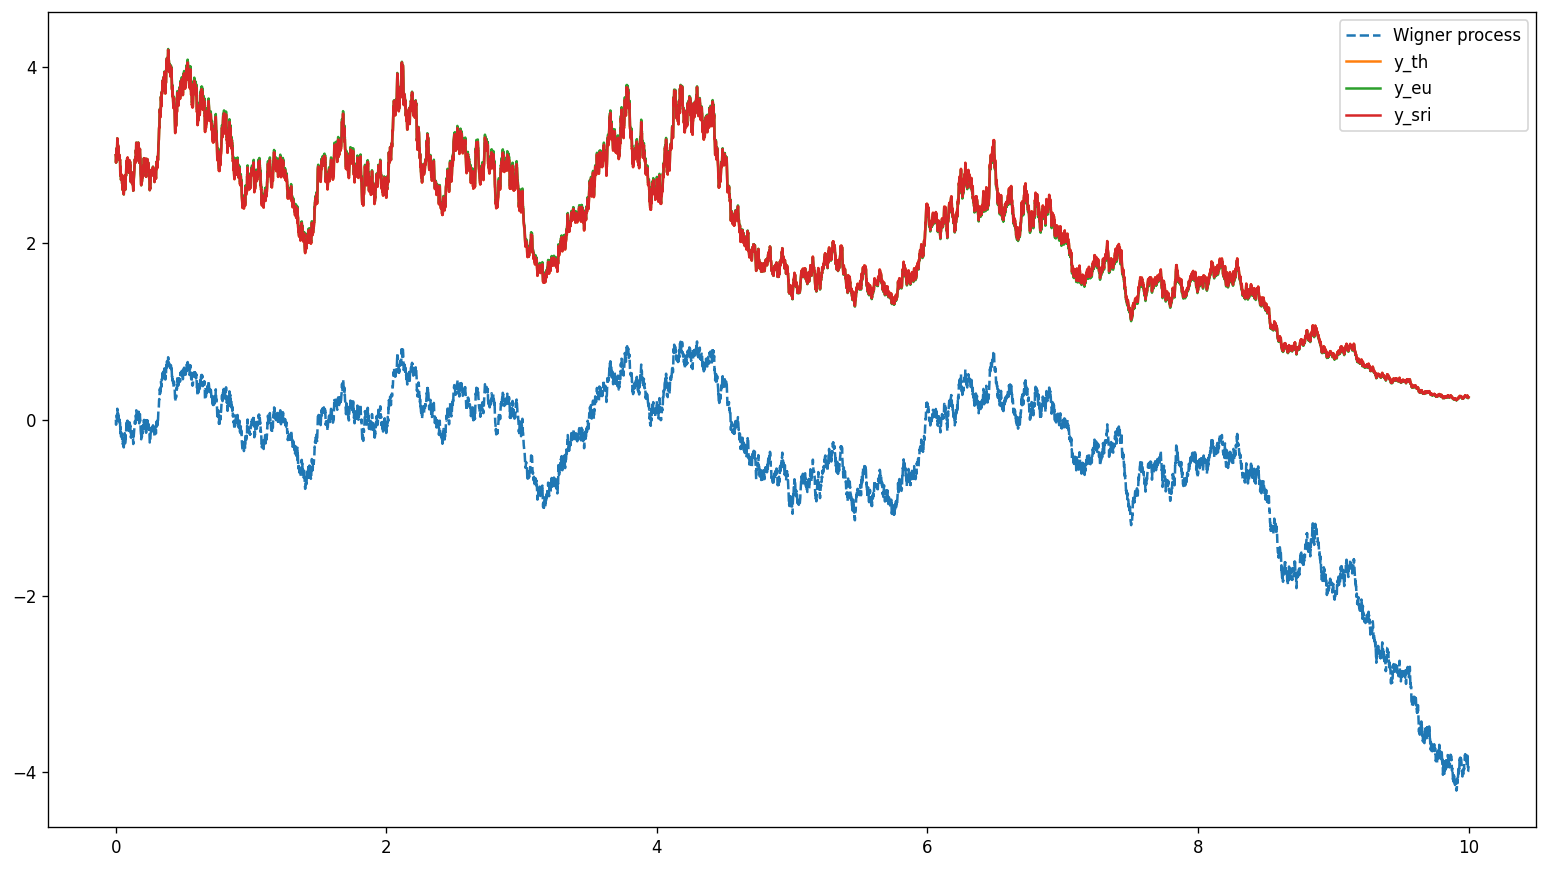

In [37]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, W, "--", label="Wigner process")
plt.plot(tspan, y_th, label="y_th")
plt.plot(tspan, y_eu, label="y_eu")
plt.plot(tspan, y_sri, label="y_sri")
plt.legend(loc="upper right")
plt.plot()

[]

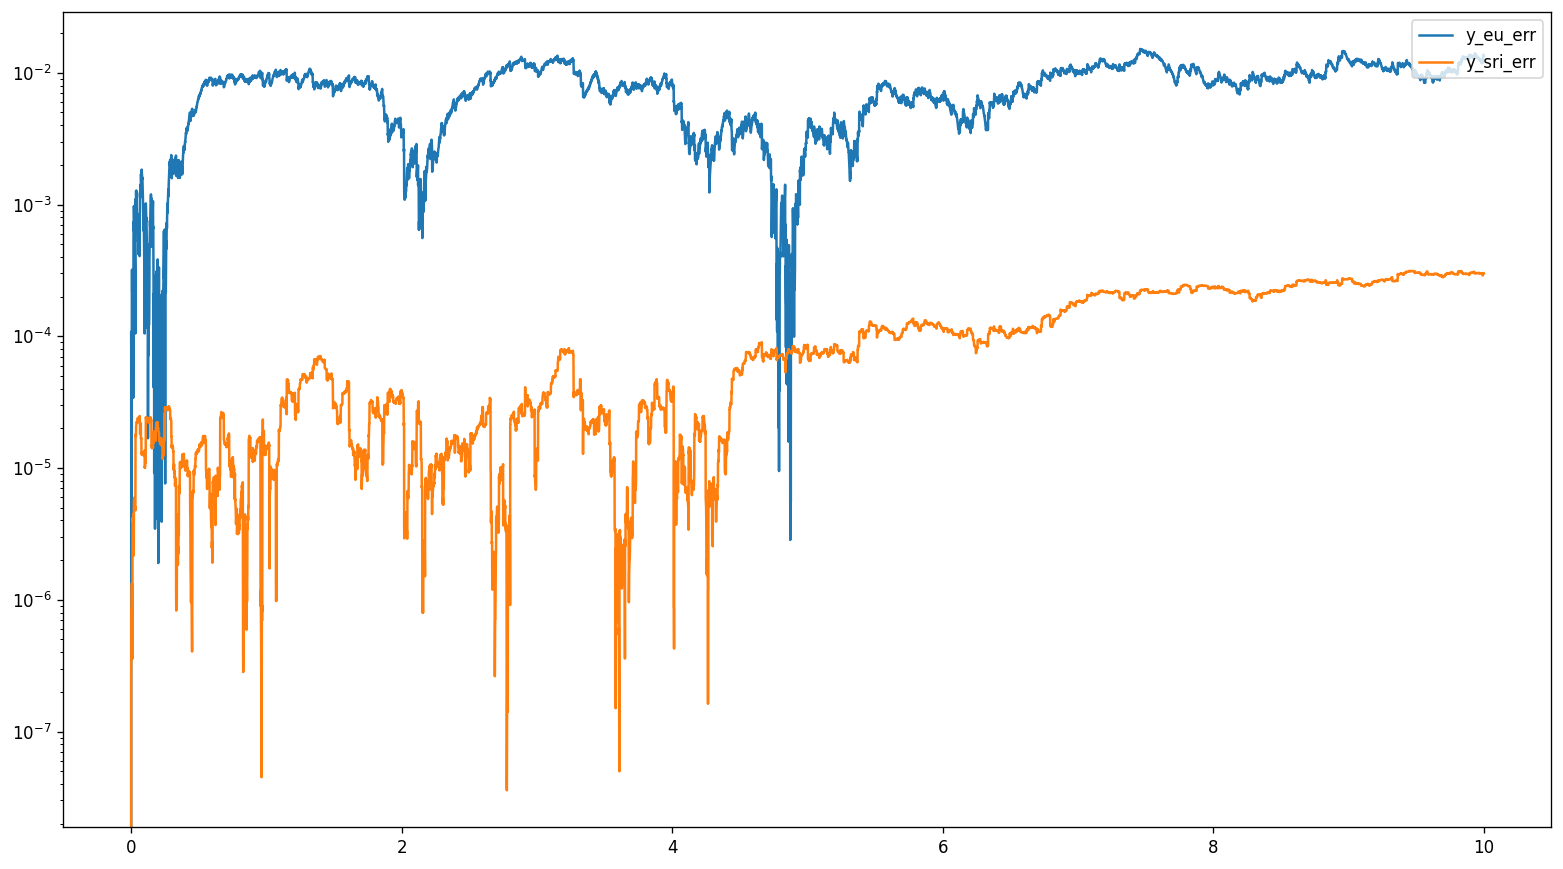

In [42]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, np.abs(y_eu[:,0]-y_th)/np.abs(y_th), label="y_eu_err")
plt.plot(tspan, np.abs(y_sri[:,0]-y_th)/np.abs(y_th), label="y_sri_err")
#plt.plot(tspan, np.abs(y_sri[:,0]-y_eu[:,0])/np.abs(y_th), label="y_sri-y_eu")
plt.yscale("log")
plt.legend(loc="upper right")
plt.plot()

In [58]:
steps = np.logspace(1, 7, 20)
euerr = []
srierr = []
for step in steps:
    ts = np.linspace(0.0, 10.0, int(step)+1)
    dt = 10.0 / step
    dw = sdeint.deltaW(len(ts)-1, 1, dt)
    y0 = 3.0
    W = np.vstack(([0.], np.cumsum(dw, axis=0)))
    y_th = y0*np.exp(a*ts + b*W[:,0])
    y_eu = sdeint.itoEuler(f1, G1, y0, ts, dW=dw)
    y_sri = sdeint.itoSRI2(f1, G1, y0, ts, Imethod=sdeint.Iwik, dW=dw)
    euerr.append(np.max(np.abs(y_eu[:,0] - y_th)))
    srierr.append(np.max(np.abs(y_sri[:,0] - y_th)))

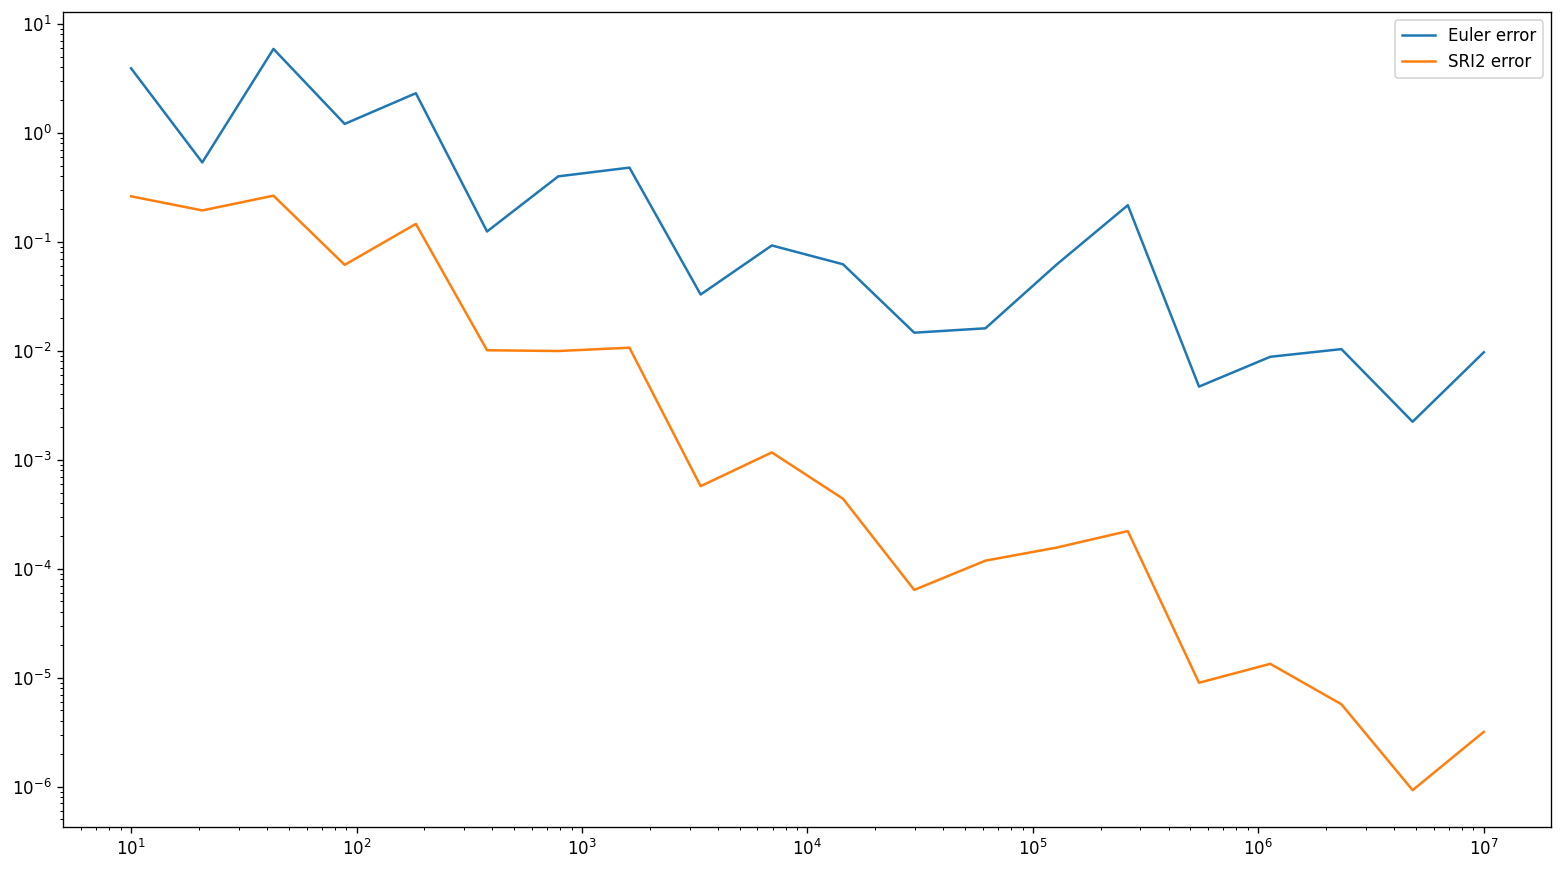

In [61]:
plt.figure(figsize=(16,9), dpi=120)
plt.plot(steps, euerr, label="Euler error")
plt.plot(steps, srierr, label="SRI2 error")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.savefig("test.pdf")

Теперь с двумя независимыми процессами:

In [415]:
a = -0.1
b1 = 0.5
b2 = -0.3
#a = -1*(0.5*b1**2 + 0.5*b2**2)   # Works aswell

tspan = np.linspace(0.0, 10.0, 10001)
dt = tspan[1:] - tspan[:-1]
#dW = np.random.normal(size=(len(tspan)-1, 2))*np.reshape(np.sqrt(dt), (-1,1))
dW = sdeint.deltaW(len(tspan)-1, 2, dt[0])
y0 = 3.0

In [416]:
# Exact solution
W = np.vstack(([0., 0.], np.cumsum(dW, axis=0)))
y_th = y0*np.exp(a*tspan + b1*W[:,0] + b2*W[:,1])

In [417]:
def f2(x, t):
    return (a + 0.5*b1**2 + 0.5*b2**2)*x

def G2(x, t):
    return np.array([b1*x, b2*x]).reshape((1,2))

y_eu = sdeint.itoEuler(f2, G2, y0, tspan, dW=dW)
y_sri = sdeint.itoSRI2(f2, G2, y0, tspan, Imethod=sdeint.Iwik, dW=dW)

[]

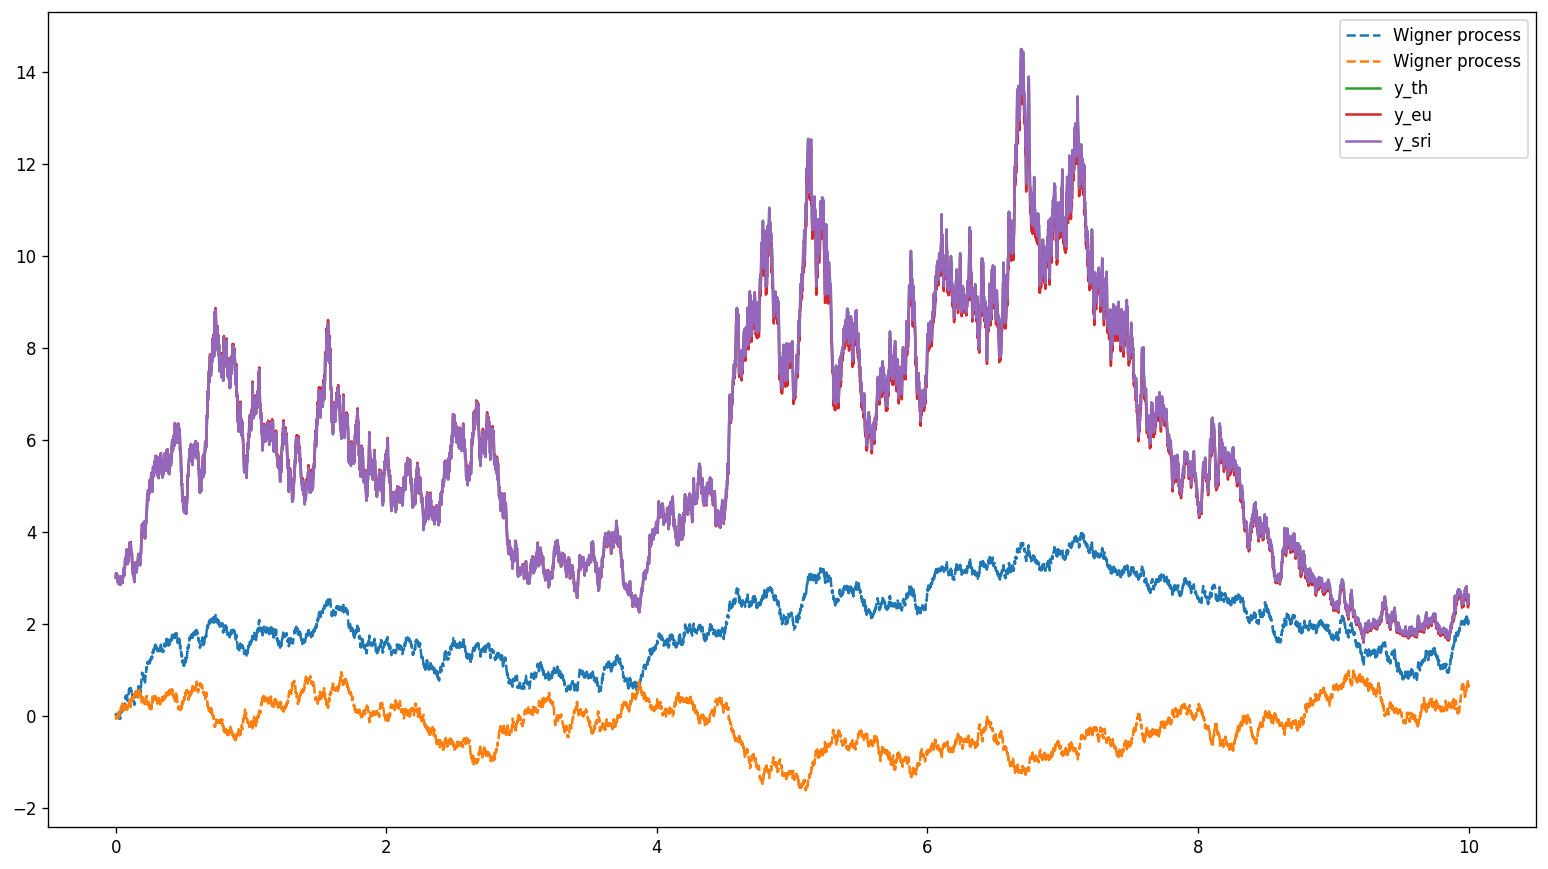

In [418]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, W, "--", label="Wigner process")
plt.plot(tspan, y_th, label="y_th")
plt.plot(tspan, y_eu, label="y_eu")
plt.plot(tspan, y_sri, label="y_sri")
plt.legend(loc="upper right")
plt.plot()

[]

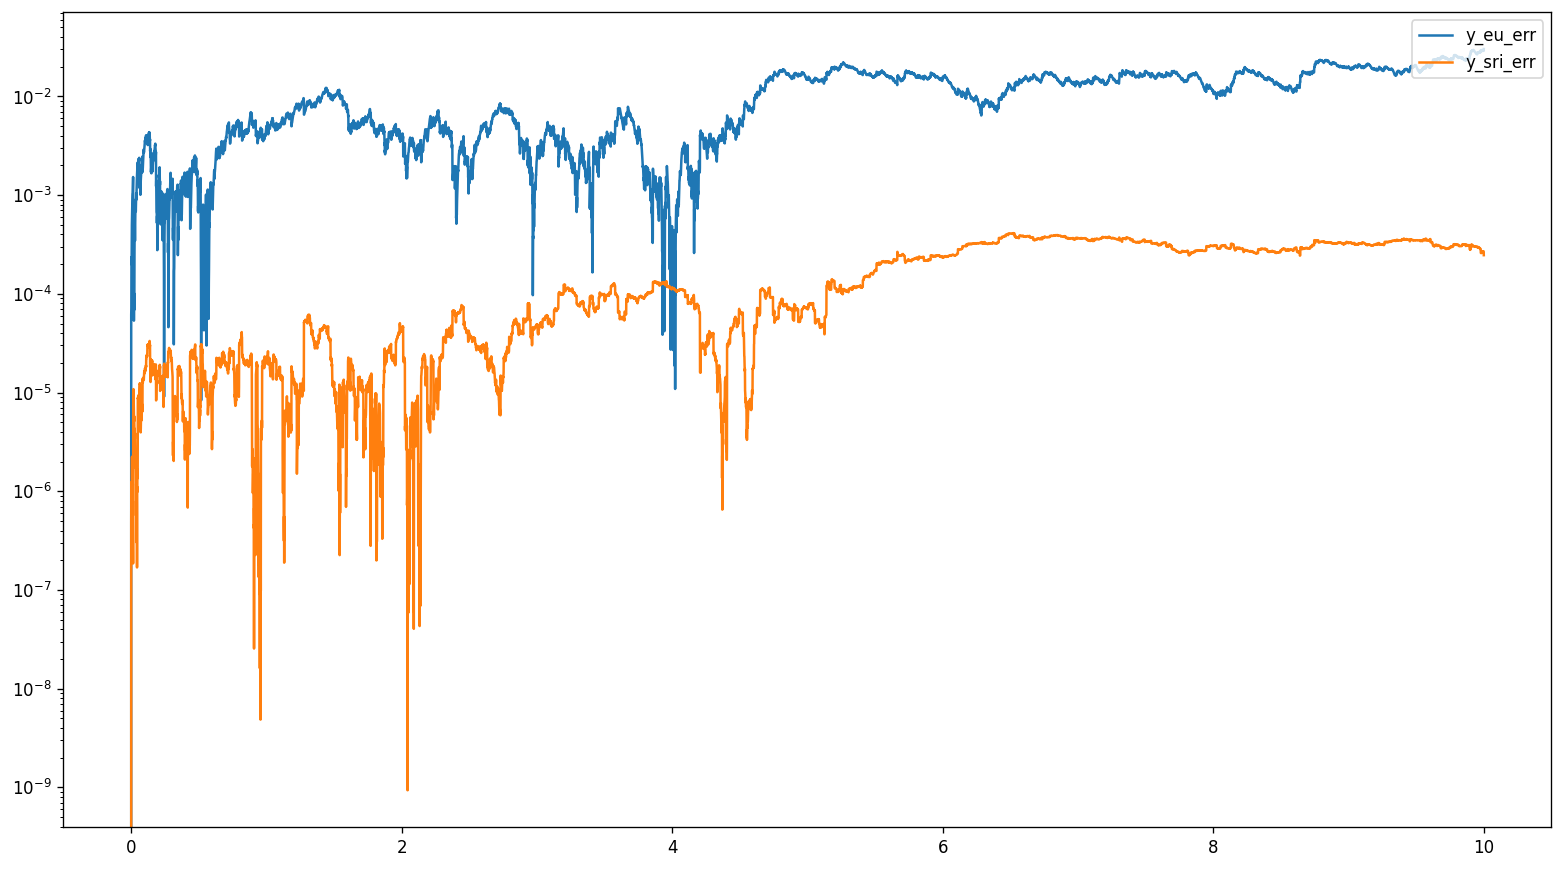

In [419]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, np.abs(y_eu[:,0]-y_th)/np.abs(y_th), label="y_eu_err")
plt.plot(tspan, np.abs(y_sri[:,0]-y_th)/np.abs(y_th), label="y_sri_err")
#plt.plot(tspan, np.abs(y_sri[:,0]-y_eu[:,0])/np.abs(y_th), label="y_sri-y_eu")
plt.yscale("log")
plt.legend(loc="upper right")
plt.plot()

Теперь колебательный:
$$
x(t) = \sin(at + bW + \text{arcsin}(x_0))
$$
$$
dx = \left(a\sqrt{1-x^2}-\frac{1}{2}b^2x\right)dt + b\sqrt{1-x^2}dW
$$

In [421]:
a = 2
b = 0.5

tspan = np.linspace(0.0, 10.0, 10001)
dt = tspan[1:] - tspan[:-1]
#dW = np.random.normal(size=(len(tspan)-1, 2))*np.reshape(np.sqrt(dt), (-1,1))
dW = sdeint.deltaW(len(tspan)-1, 1, dt[0])
y0 = 0.5

In [422]:
# Exact solution
W = np.vstack(([0.], np.cumsum(dW, axis=0)))
y_th = np.sin(a*tspan + b*W[:,0] + np.arcsin(y0))

In [423]:
change = 1
def f3(x, t):
    global change
    if x > 1:
        x = 2 - x
        change = -1
    if x < -1:
        x = -2 - x
        change = 1
    return change*a*np.sqrt(1-x**2)-0.5*b**2*x


def G3(x, t):
    global change
    if x > 1:
        x = 2 - x
        change = -1
    if x < -1:
        x = -2 - x
        change = 1
    return change*b*np.sqrt(1-x**2)

y_eu = sdeint.itoEuler(f3, G3, y0, tspan, dW=dW)
change=1
y_sri = sdeint.itoSRI2(f3, G3, y0, tspan, Imethod=sdeint.Iwik, dW=dW)

[]

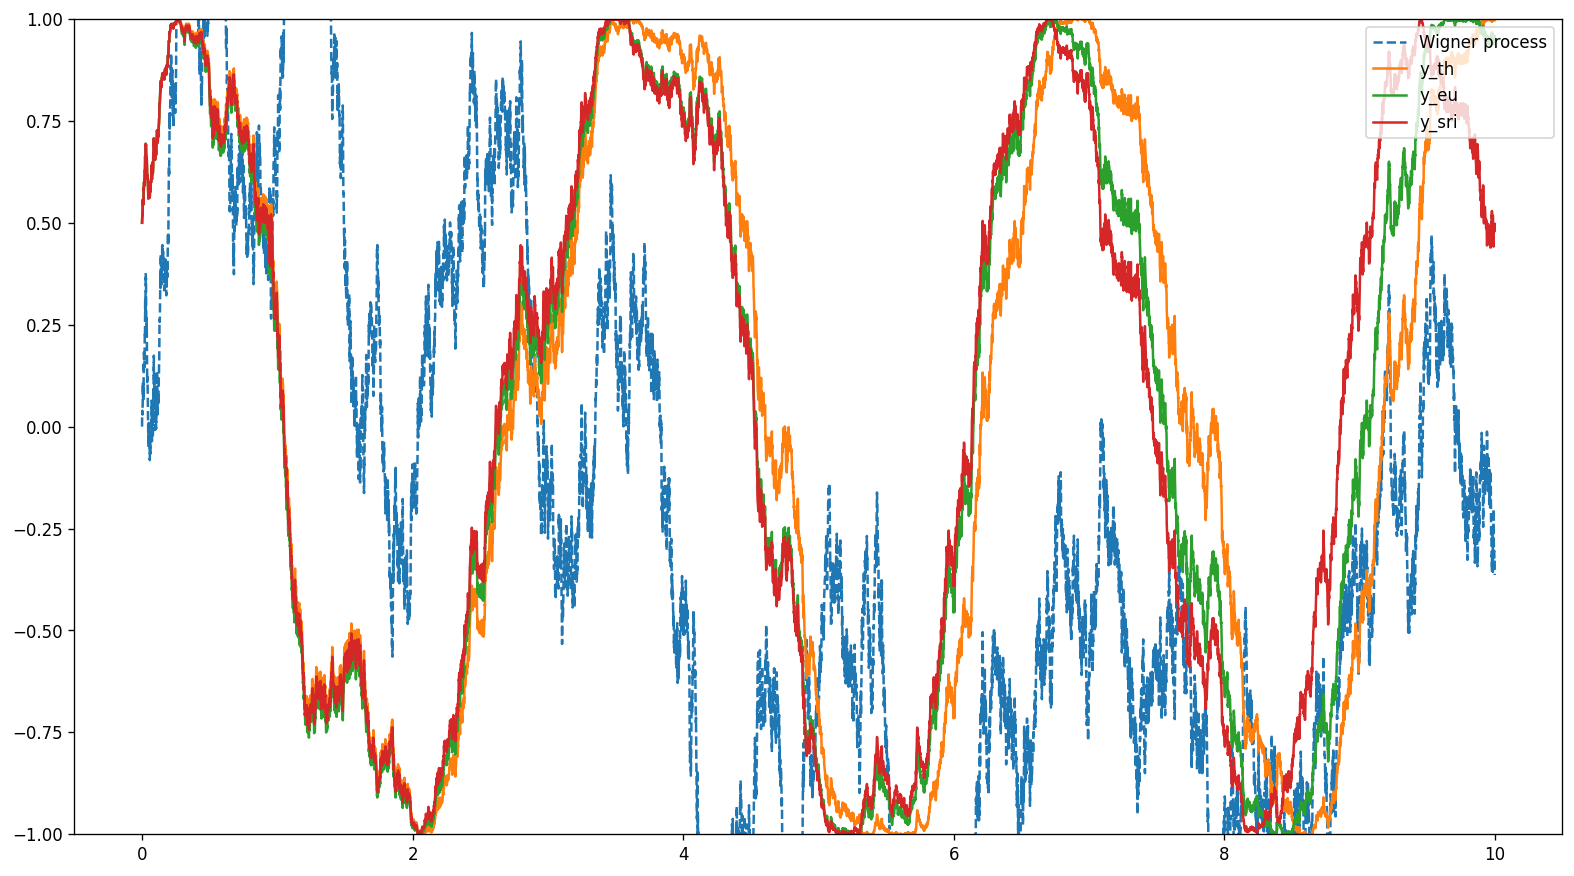

In [424]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, W, "--", label="Wigner process")
plt.plot(tspan, y_th, label="y_th")
plt.plot(tspan, y_eu, label="y_eu")
plt.plot(tspan, y_sri, label="y_sri")
plt.ylim((-1,1))
plt.legend(loc="upper right")
plt.plot()

[]

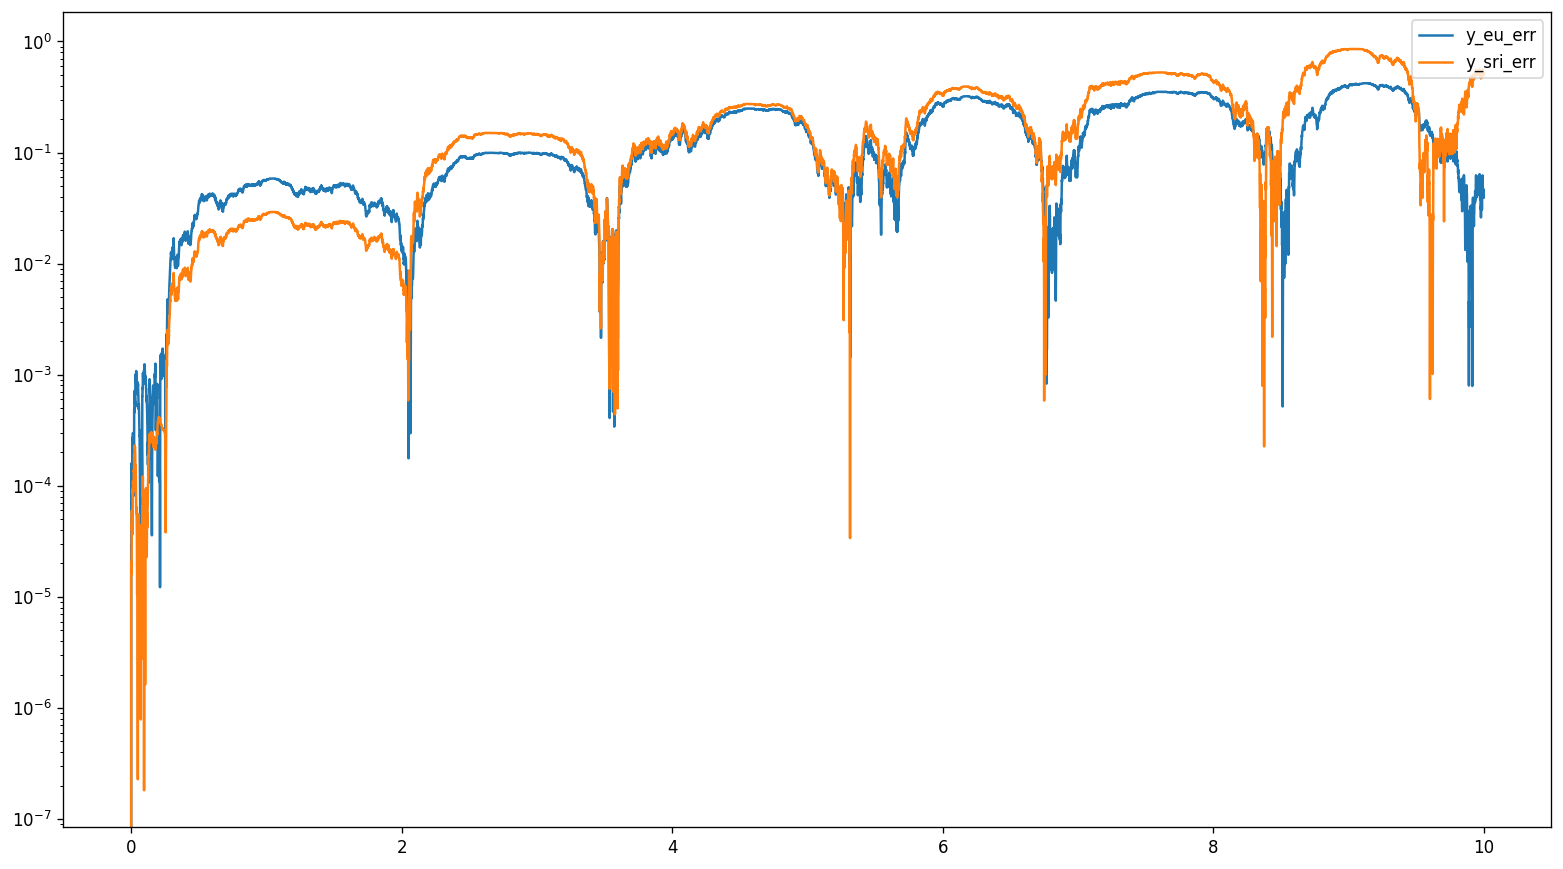

In [425]:
plt.figure(figsize=(16, 9), dpi=120)
plt.plot(tspan, np.abs(y_eu[:,0]-y_th), label="y_eu_err")
plt.plot(tspan, np.abs(y_sri[:,0]-y_th), label="y_sri_err")
#plt.plot(tspan, np.abs(y_sri[:,0]-y_eu[:,0])/np.abs(y_th), label="y_sri-y_eu")
plt.yscale("log")
plt.legend(loc="upper right")
plt.plot()

Попробуем повторить статью
$$
X(t) = 
$$